### Importing necessary classes

In [4]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Load your dataset
data = pd.read_csv("/content/drive/MyDrive/MSc Dessertation/DATASETS/WinnipegDataset.txt")# Separate features and labels for the entire dataset
X_baseline = data.drop(columns=['label'])
y_baseline = data['label']

# Train-test split for the baseline model using all features
X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(
    X_baseline, y_baseline, test_size=0.2, random_state=42
)
# Calculate the correlation of each feature with the target 'label'
correlation = data.corr()

# Sort by absolute correlation with 'label'
correlation_with_label = correlation['label'].abs().sort_values(ascending=False)

# Select top 60 features based on correlation, excluding 'label'
top_60_features = correlation_with_label.index[1:61]  # Exclude 'label' itself (index[1:61])

# Create X with the top 60 features, excluding 'label'
X = data[top_60_features]

# Sample 10,000 rows for testing (from both X and y)
data_sampled = data.sample(n=20000, random_state=42)


## Reading insights of the dataset

In [7]:

# Create X and y based on the sampled data
X_sampled = data_sampled[top_60_features]
y = data_sampled['label']

# Split the sampled dataset
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y, test_size=0.2, random_state=42)

# Print the shapes to verify
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


X_train shape: (16000, 60)
y_train shape: (16000,)


In [8]:
data.head()

,label,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
0,1,-13.559,-21.407,-11.4040,-15.248,-11.923,-15.291,-2.1548,-7.8474,-10.0020,...,0.18519,0.72602,5.3333,6.000000,0.29489,9.77780,2.44440,1.67700,0.20988,0.65422
1,1,-12.802,-20.335,-10.3990,-14.132,-11.096,-14.361,-2.4039,-7.5330,-9.9369,...,0.33333,-0.48751,2.1111,0.098765,0.83333,0.33333,0.33333,0.84869,0.50617,-0.18898
2,1,-12.431,-19.902,-10.0740,-13.598,-10.829,-14.048,-2.3566,-7.4717,-9.8283,...,0.25926,0.25298,2.2222,0.172840,0.68889,0.88889,0.66667,1.27300,0.30864,0.10483
3,1,-12.689,-19.529,-10.0280,-13.350,-11.056,-14.014,-2.6611,-6.8396,-9.5006,...,0.16049,0.43750,4.1111,0.320990,0.83333,0.33333,0.33333,1.14910,0.38272,0.41603
4,1,-12.686,-19.278,-9.8185,-13.108,-10.932,-13.939,-2.8675,-6.5919,-9.4594,...,0.18519,0.35000,4.0000,0.444440,0.68889,0.88889,0.66667,1.58110,0.20988,0.50000


In [9]:
# Basic information about the dataset
print("Dataset Info:")
print(data.info())

# First few rows of the dataset
print("\nFirst 5 rows:")
print(data.head())

# Summary statistics
print("\nSummary Statistics:")
print(data.describe())

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())

# Check for duplicate rows
print("\nDuplicate Rows:", data.duplicated().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325834 entries, 0 to 325833
Columns: 175 entries, label to f174
dtypes: float64(169), int64(6)
memory usage: 435.0 MB
None

First 5 rows:
   label      f1      f2       f3      f4      f5      f6      f7      f8  \
0      1 -13.559 -21.407 -11.4040 -15.248 -11.923 -15.291 -2.1548 -7.8474   
1      1 -12.802 -20.335 -10.3990 -14.132 -11.096 -14.361 -2.4039 -7.5330   
2      1 -12.431 -19.902 -10.0740 -13.598 -10.829 -14.048 -2.3566 -7.4717   
3      1 -12.689 -19.529 -10.0280 -13.350 -11.056 -14.014 -2.6611 -6.8396   
4      1 -12.686 -19.278  -9.8185 -13.108 -10.932 -13.939 -2.8675 -6.5919   

        f9  ...     f165     f166    f167      f168     f169     f170  \
0 -10.0020  ...  0.18519  0.72602  5.3333  6.000000  0.29489  9.77780   
1  -9.9369  ...  0.33333 -0.48751  2.1111  0.098765  0.83333  0.33333   
2  -9.8283  ...  0.25926  0.25298  2.2222  0.172840  0.68889  0.88889   
3  -9.5006  ...  0.16049  0.43750  4.1111  

### Optimisation and baseline model creation


In [10]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
rf_baseline = RandomForestClassifier(random_state=42)

# Train the model
rf_baseline.fit(X_train, y_train)

# Evaluate the model
baseline_accuracy = rf_baseline.score(X_test, y_test)
print(f"Baseline Model Accuracy: {baseline_accuracy*100:.2f}%")


Baseline Model Accuracy: 98.15%


In [11]:
# Models with parallel processing
baseline_model = RandomForestClassifier(n_jobs=-1)  # Random Forest with parallel processing
logistic_model = LogisticRegression(max_iter=1000, C=0.1, n_jobs=-1)

Baseline Model Accuracy: 98.22%

Classification Report:
              precision    recall  f1-score   support

           1       0.99      0.98      0.98       492
           2       0.98      0.98      0.98        46
           3       0.99      0.99      0.99       937
           4       0.99      0.98      0.98       929
           5       0.98      0.95      0.97       546
           6       0.97      0.99      0.98      1033
           7       0.84      0.94      0.89        17

    accuracy                           0.98      4000
   macro avg       0.96      0.97      0.97      4000
weighted avg       0.98      0.98      0.98      4000


Confusion Matrix:
[[ 481    1    0    7    1    0    2]
 [   0   45    0    1    0    0    0]
 [   1    0  932    3    1    0    0]
 [   3    0    3  913    2    8    0]
 [   0    0    2    0  521   23    0]
 [   1    0    2    1    7 1021    1]
 [   1    0    0    0    0    0   16]]


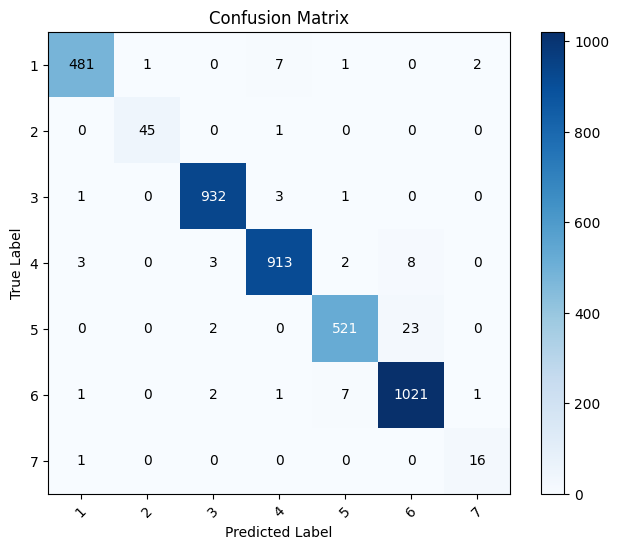

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Fit the baseline model
baseline_model.fit(X_train, y_train)

# Predict on the test set
y_pred_baseline = baseline_model.predict(X_test)

# Calculate accuracy in percentage
accuracy_baseline = accuracy_score(y_test, y_pred_baseline) * 100
print(f"Baseline Model Accuracy: {accuracy_baseline:.2f}%")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_baseline)
print("\nConfusion Matrix:")
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
classes = np.unique(y_test)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.grid(False)

# Add values in the confusion matrix cells
thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")
plt.show()

# AUC-ROC Calculation (if it's a binary classification problem)
if len(classes) == 2:
    y_proba_baseline = baseline_model.predict_proba(X_test)[:, 1]
    auc_baseline = roc_auc_score(y_test, y_proba_baseline)
    print(f"AUC-ROC Score: {auc_baseline:.4f}")

    # Plot the ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba_baseline)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_baseline:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


In [13]:
# SDS Class Definition
class SDS:
    def __init__(self, n_agents, n_iterations, model):
        self.n_agents = n_agents
        self.n_iterations = n_iterations
        self.model = model
        self.best_feature_subset = None
        self.best_accuracy = 0.0

    def initialize_agents(self, n_features):
        agents = []
        for _ in range(self.n_agents):
            agent_features = np.random.choice([0, 1], size=n_features)
            agents.append(agent_features)
        return np.array(agents)

    def evaluate(self, agent_features, X, y):
        selected_features = np.where(agent_features == 1)[0]
        if len(selected_features) == 0:
            return 0.0
        X_selected = X[:, selected_features]
        self.model.fit(X_selected, y)
        predictions = self.model.predict(X_selected)
        return accuracy_score(y, predictions)

    def evaluate_all_agents(self, agents, X, y):
        return Parallel(n_jobs=-1)(delayed(self.evaluate)(agent, X, y) for agent in agents)

    def search(self, X_train, y_train):
        n_features = X_train.shape[1]
        agents = self.initialize_agents(n_features)

        for iteration in range(self.n_iterations):
            print(f"Iteration {iteration + 1}/{self.n_iterations}")

            # Parallel evaluation of all agents
            accuracies = self.evaluate_all_agents(agents, X_train, y_train)

            # Update the best agent based on accuracies
            for i, accuracy in enumerate(accuracies):
                if accuracy > self.best_accuracy:
                    self.best_accuracy = accuracy
                    self.best_feature_subset = agents[i].copy()
                    print(f"New best accuracy: {self.best_accuracy:.4f} with features {np.where(agents[i] == 1)[0]}")

            # Diffuse the best feature subset
            for i in range(len(agents)):
                agents[i] = self.best_feature_subset if np.random.rand() > 0.5 else agents[i]

        print(f"Best Feature Subset: {np.where(self.best_feature_subset == 1)[0]}")
        return self.best_feature_subset

## Applying Stochastic Diffusion Search (SDS)

Iteration 1/5
New best accuracy: 1.0000 with features [ 0  3  5  8  9 10 13 16 17 21 22 23 24 26 27 28 30 34 36 39 42 45 47 50
 51 52 54 55 56 57 58 59]
Iteration 2/5
Iteration 3/5
Iteration 4/5
Iteration 5/5
Best Feature Subset: [ 0  3  5  8  9 10 13 16 17 21 22 23 24 26 27 28 30 34 36 39 42 45 47 50
 51 52 54 55 56 57 58 59]
SDS Model Accuracy: 97.55%

Classification Report for SDS Model:
              precision    recall  f1-score   support

           1       0.99      0.98      0.98       492
           2       0.96      0.98      0.97        46
           3       0.99      0.99      0.99       937
           4       0.98      0.98      0.98       929
           5       0.96      0.93      0.95       546
           6       0.96      0.98      0.97      1033
           7       0.89      0.94      0.91        17

    accuracy                           0.98      4000
   macro avg       0.96      0.97      0.96      4000
weighted avg       0.98      0.98      0.98      4000


Confusio

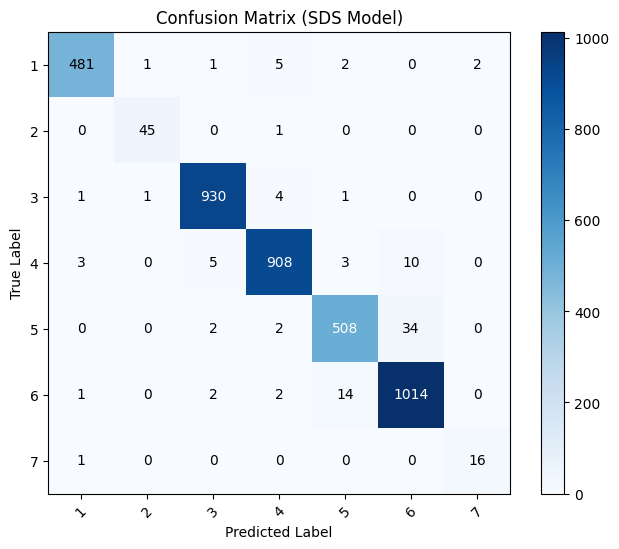

In [14]:
# SDS Feature Selection with Parallel Evaluation
sds_optimizer = SDS(n_agents=10, n_iterations=5, model=baseline_model)
best_features_sds = sds_optimizer.search(X_train.values, y_train.values)

# Selecting features based on SDS optimization
X_train_sds = X_train.values[:, np.where(best_features_sds == 1)[0]]
X_test_sds = X_test.values[:, np.where(best_features_sds == 1)[0]]

# Train the model on the selected features
baseline_model.fit(X_train_sds, y_train)

# Predict on the test set
y_pred_sds = baseline_model.predict(X_test_sds)

# Calculate accuracy in percentage
accuracy_sds = accuracy_score(y_test, y_pred_sds) * 100
print(f"SDS Model Accuracy: {accuracy_sds:.2f}%")

# Print the classification report
print("\nClassification Report for SDS Model:")
print(classification_report(y_test, y_pred_sds))

# Confusion Matrix
cm_sds = confusion_matrix(y_test, y_pred_sds)
print("\nConfusion Matrix for SDS Model:")
print(cm_sds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm_sds, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (SDS Model)")
plt.colorbar()
classes = np.unique(y_test)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.grid(False)

# Add values in the confusion matrix cells
thresh = cm_sds.max() / 2
for i, j in np.ndindex(cm_sds.shape):
    plt.text(j, i, format(cm_sds[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm_sds[i, j] > thresh else "black")
plt.show()

# AUC-ROC Calculation (if it's a binary classification problem)
if len(classes) == 2:
    y_proba_sds = baseline_model.predict_proba(X_test_sds)[:, 1]
    auc_sds = roc_auc_score(y_test, y_proba_sds)
    print(f"AUC-ROC Score for SDS Model: {auc_sds:.4f}")

    # Plot the ROC Curve
    fpr_sds, tpr_sds, _ = roc_curve(y_test, y_proba_sds)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_sds, tpr_sds, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_sds:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve (SDS Model)')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


## Applying Principal Component Analysis (PCA)

PCA Model Accuracy: 72.12%

Classification Report for PCA Model:
              precision    recall  f1-score   support

           1       0.93      0.86      0.89       492
           2       0.74      0.43      0.55        46
           3       0.94      0.97      0.96       937
           4       0.63      0.57      0.60       929
           5       0.45      0.46      0.46       546
           6       0.65      0.72      0.68      1033
           7       0.00      0.00      0.00        17

    accuracy                           0.72      4000
   macro avg       0.62      0.58      0.59      4000
weighted avg       0.72      0.72      0.72      4000


Confusion Matrix for PCA Model:
[[424   0   0   8  22  38   0]
 [  0  20  25   1   0   0   0]
 [  0   7 908  18   4   0   0]
 [  4   0  24 533 156 212   0]
 [ 12   0   2 135 253 144   0]
 [ 15   0   2 142 127 747   0]
 [  1   0   1   4   3   8   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


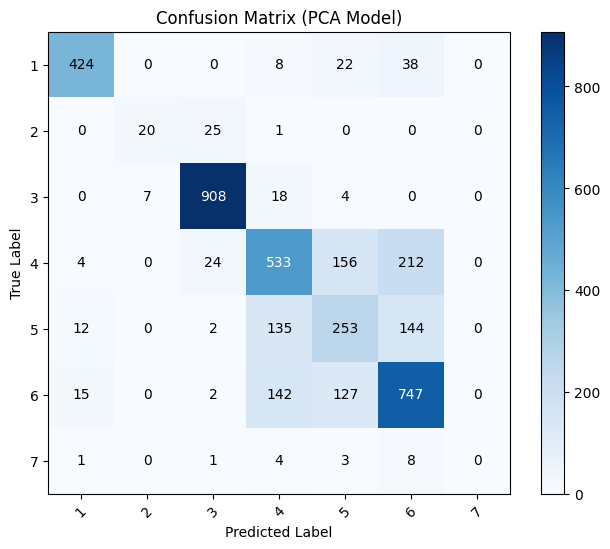

In [15]:
# PCA Dimensionality Reduction
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train the baseline model on the PCA-reduced features
baseline_model.fit(X_train_pca, y_train)

# Predict on the test set
y_pred_pca = baseline_model.predict(X_test_pca)

# Calculate accuracy in percentage
accuracy_pca = accuracy_score(y_test, y_pred_pca) * 100
print(f"PCA Model Accuracy: {accuracy_pca:.2f}%")

# Print the classification report
print("\nClassification Report for PCA Model:")
print(classification_report(y_test, y_pred_pca))

# Confusion Matrix
cm_pca = confusion_matrix(y_test, y_pred_pca)
print("\nConfusion Matrix for PCA Model:")
print(cm_pca)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm_pca, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (PCA Model)")
plt.colorbar()
classes = np.unique(y_test)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.grid(False)

# Add values in the confusion matrix cells
thresh = cm_pca.max() / 2
for i, j in np.ndindex(cm_pca.shape):
    plt.text(j, i, format(cm_pca[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm_pca[i, j] > thresh else "black")
plt.show()

# AUC-ROC Calculation (if it's a binary classification problem)
if len(classes) == 2:
    y_proba_pca = baseline_model.predict_proba(X_test_pca)[:, 1]
    auc_pca = roc_auc_score(y_test, y_proba_pca)
    print(f"AUC-ROC Score for PCA Model: {auc_pca:.4f}")

    # Plot the ROC Curve
    fpr_pca, tpr_pca, _ = roc_curve(y_test, y_proba_pca)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_pca, tpr_pca, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_pca:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve (PCA Model)')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


In [16]:
# Display the best components selected by PCA
print(f"Principal components selected by PCA: {np.arange(pca.n_components_)}")

Principal components selected by PCA: [0 1]


## Applying Recursive Feature Elimination (RFE)

RFE Model Accuracy: 97.52%

Classification Report for RFE Model:
              precision    recall  f1-score   support

           1       0.97      0.98      0.98       492
           2       0.98      0.98      0.98        46
           3       0.99      0.99      0.99       937
           4       0.98      0.98      0.98       929
           5       0.96      0.94      0.95       546
           6       0.96      0.97      0.97      1033
           7       0.94      0.94      0.94        17

    accuracy                           0.98      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.98      0.98      0.98      4000


Confusion Matrix for RFE Model:
[[ 482    1    1    5    1    1    1]
 [   0   45    0    1    0    0    0]
 [   0    0  932    3    1    1    0]
 [   5    0    4  907    2   11    0]
 [   2    0    1    1  512   30    0]
 [   5    0    2    4   15 1007    0]
 [   1    0    0    0    0    0   16]]


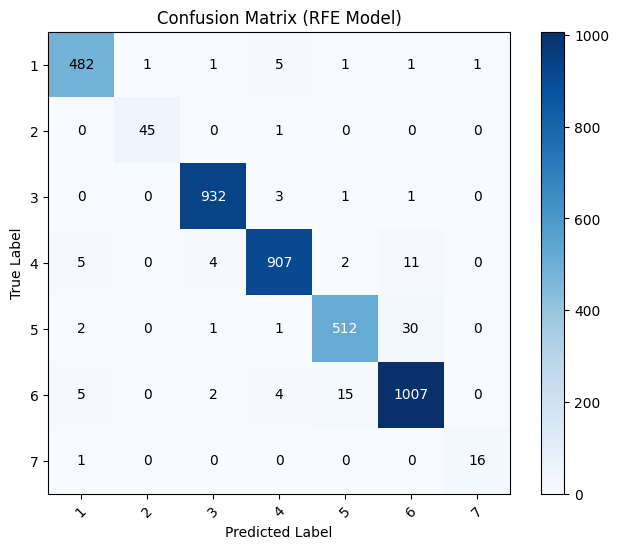

In [17]:
# RFE Feature Selection with Parallel Processing
rfe = RFE(estimator=RandomForestClassifier(n_jobs=-1), n_features_to_select=7)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

# Train the baseline model on the RFE-selected features
baseline_model.fit(X_train_rfe, y_train)

# Predict on the test set
y_pred_rfe = baseline_model.predict(X_test_rfe)

# Calculate accuracy in percentage
accuracy_rfe = accuracy_score(y_test, y_pred_rfe) * 100
print(f"RFE Model Accuracy: {accuracy_rfe:.2f}%")

# Print the classification report
print("\nClassification Report for RFE Model:")
print(classification_report(y_test, y_pred_rfe))

# Confusion Matrix
cm_rfe = confusion_matrix(y_test, y_pred_rfe)
print("\nConfusion Matrix for RFE Model:")
print(cm_rfe)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm_rfe, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (RFE Model)")
plt.colorbar()
classes = np.unique(y_test)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.grid(False)

# Add values in the confusion matrix cells
thresh = cm_rfe.max() / 2
for i, j in np.ndindex(cm_rfe.shape):
    plt.text(j, i, format(cm_rfe[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm_rfe[i, j] > thresh else "black")
plt.show()

# AUC-ROC Calculation (if it's a binary classification problem)
if len(classes) == 2:
    y_proba_rfe = baseline_model.predict_proba(X_test_rfe)[:, 1]
    auc_rfe = roc_auc_score(y_test, y_proba_rfe)
    print(f"AUC-ROC Score for RFE Model: {auc_rfe:.4f}")

    # Plot the ROC Curve
    fpr_rfe, tpr_rfe, _ = roc_curve(y_test, y_proba_rfe)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_rfe, tpr_rfe, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_rfe:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve (RFE Model)')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


In [18]:
# Display the best features selected by RFE
best_features_rfe = np.where(rfe.support_)[0]
print(f"Best features selected by RFE: {best_features_rfe}")

Best features selected by RFE: [ 1 17 18 26 46 54 56]


In [19]:
# Display the best components selected by PCA
print(f"Principal components selected by PCA: {np.arange(pca.n_components_)}")

Principal components selected by PCA: [0 1]


## Relationships Between Features and Target Variable

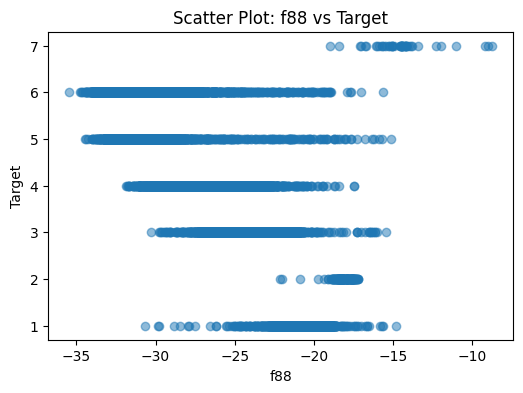

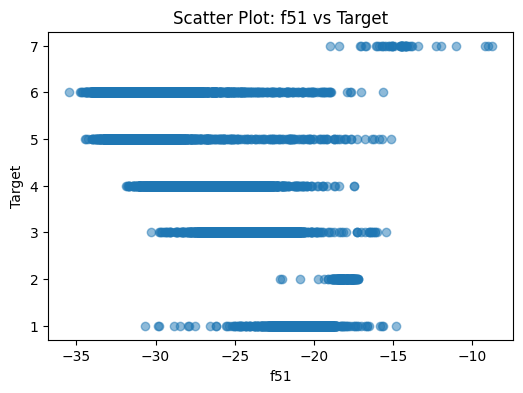

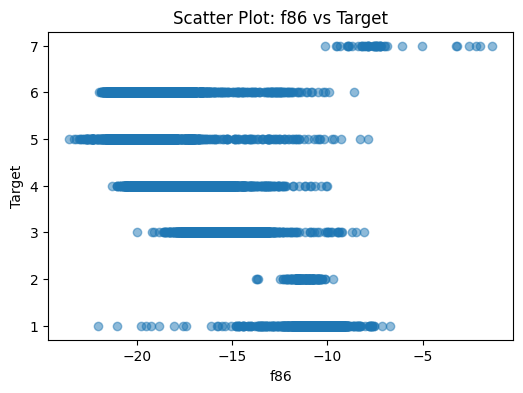

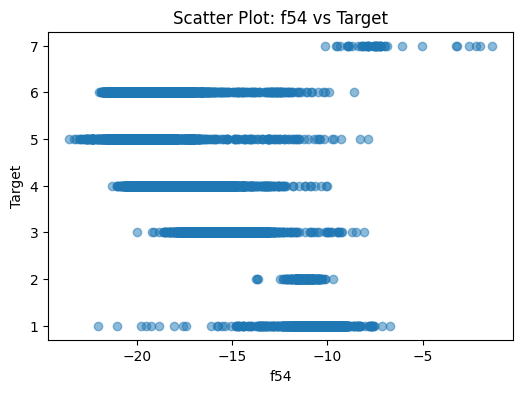

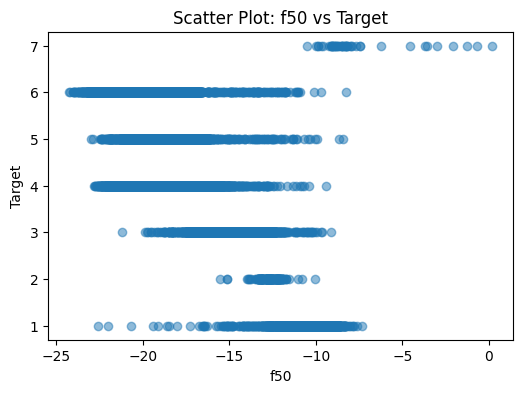

In [20]:
import matplotlib.pyplot as plt #c

for feature in X_train.columns[:5]:  # Visualize the first 5 features
    plt.figure(figsize=(6, 4))
    plt.scatter(X_train[feature], y_train, alpha=0.5)
    plt.title(f'Scatter Plot: {feature} vs Target')
    plt.xlabel(feature)
    plt.ylabel('Target')
    plt.show()


## Applying Filter Method - Mutual Information

In [21]:
# Step 1: Apply Mutual Information for Filter Method
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

# Calculate mutual information for each feature with the label
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Mutual_Info': mutual_info
}).sort_values(by='Mutual_Info', ascending=False)

# Set a threshold or select top features based on mutual information
mutual_info_threshold = 0.01  # Threshold for relevance (tune as needed)
selected_features_filter = mutual_info_df[mutual_info_df['Mutual_Info'] > mutual_info_threshold]['Feature']

# Create filtered feature datasets
X_train_filter = X_train[selected_features_filter]
X_test_filter = X_test[selected_features_filter]

# Step 2: Train and evaluate a model using the filter method
baseline_model = RandomForestClassifier(n_jobs=-1)  # Replace with your preferred model
baseline_model.fit(X_train_filter, y_train)
y_pred_filter = baseline_model.predict(X_test_filter)
accuracy_filter = accuracy_score(y_test, y_pred_filter)

# Step 3: Generate confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred_filter)
class_report = classification_report(y_test, y_pred_filter)

# Step 4: Compute AUC-ROC if applicable
if len(set(y_test)) == 2:  # Check if it's a binary classification
    y_prob = baseline_model.predict_proba(X_test_filter)[:, 1]
    auc_score = roc_auc_score(y_test, y_prob)
    print(f"AUC-ROC Score: {auc_score:.4f}")

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

# Step 5: Display results for the filter method
print(f"Features selected by the filter method (Mutual Information > {mutual_info_threshold}): {list(selected_features_filter)}")
print(f"Accuracy using filtered features: {accuracy_filter:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


Features selected by the filter method (Mutual Information > 0.01): ['f88', 'f51', 'f25', 'f89', 'f100', 'f86', 'f40', 'f54', 'f76', 'f94', 'f5', 'f37', 'f95', 'f92', 'f1', 'f74', 'f50', 'f52', 'f27', 'f39', 'f2', 'f115', 'f45', 'f46', 'f3', 'f4', 'f41', 'f55', 'f75', 'f6', 'f38', 'f98', 'f129', 'f90', 'f49', 'f87', 'f53', 'f43', 'f26', 'f47', 'f96', 'f93', 'f159', 'f44', 'f141', 'f58', 'f78', 'f81', 'f154', 'f153', 'f151', 'f152', 'f142', 'f147', 'f143', 'f149', 'f150', 'f144', 'f148', 'f91']
Accuracy using filtered features: 0.9830

Confusion Matrix:
 [[ 481    1    1    6    1    0    2]
 [   0   45    0    1    0    0    0]
 [   1    0  932    3    1    0    0]
 [   3    0    3  913    2    8    0]
 [   1    0    1    1  521   22    0]
 [   1    0    2    1    5 1024    0]
 [   1    0    0    0    0    0   16]]

Classification Report:
               precision    recall  f1-score   support

           1       0.99      0.98      0.98       492
           2       0.98      0.98      

In [22]:
# Summary of Results
results = {
    'Method': ['Baseline','SDS', 'RFE', 'PCA','Filter Method'],  # Added Filter Method
    'Accuracy': [ accuracy_baseline, accuracy_sds, accuracy_rfe, accuracy_pca,accuracy_filter]  # Add accuracy_filter
}

# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Add the number of features for each method
results_df['Num_Features'] = results_df['Method'].map({
    'Baseline': X_train.shape[1], # Total number of features in the original dataset
    'SDS': np.sum(best_features_sds == 1),
    'RFE': len(best_features_rfe),
    'PCA': pca.n_components_,

    'Filter Method': len(selected_features_filter)  # Number of features selected by the filter method
})

# Print the updated results DataFrame
print(results_df)


          Method  Accuracy  Num_Features
0       Baseline    98.225            60
1            SDS    97.550            32
2            RFE    97.525             7
3            PCA    72.125             2
4  Filter Method     0.983            60


In [23]:
results_df

,Method,Accuracy,Num_Features
0,Baseline,98.225,60
1,SDS,97.550,32
2,RFE,97.525,7
3,PCA,72.125,2
4,Filter Method,0.983,60


In [24]:
# Import the required module
import plotly.graph_objects as go

# Visualization Update: Add Filter Method to the Bar and Line Plot
fig = go.Figure()

# Bar plot for Accuracy
fig.add_trace(go.Bar(
    x=results_df['Method'],
    y=results_df['Accuracy'],
    name='Accuracy',
    marker=dict(color='blue'),
    yaxis='y1'  # Primary y-axis
))

# Line plot for Number of Features
fig.add_trace(go.Scatter(
    x=results_df['Method'],
    y=results_df['Num_Features'],
    name='Number of Features',
    mode='lines+markers',
    line=dict(color='red', width=2),
    yaxis='y2'  # Secondary y-axis
))

# Update layout with dual y-axes
fig.update_layout(
    title="Accuracy and Number of Features by Method",
    xaxis=dict(title='Method'),
    yaxis=dict(
        title='Accuracy',
        range=[0, 1],
        side='left'
    ),
    yaxis2=dict(
        title='Number of Features',
        overlaying='y',
        side='right'
    ),
    showlegend=True
)

# Show the interactive plot
fig.show()


In [25]:
# Create a bar plot using Plotly c
import plotly.graph_objects as go

fig = go.Figure()

# Bar plot for Accuracy
fig.add_trace(go.Bar(
    x=results_df['Method'],
    y=results_df['Accuracy'],
    name='Accuracy',
    marker=dict(color=px.colors.sequential.Viridis[0]),
    yaxis='y1'  # Primary y-axis
))

# Line plot for Number of Features
fig.add_trace(go.Scatter(
    x=results_df['Method'],
    y=results_df['Num_Features'],
    name='Number of Features',
    mode='lines+markers',
    line=dict(color='red', width=2),
    yaxis='y2'  # Secondary y-axis
))

# Update layout with dual y-axes
fig.update_layout(
    title="Accuracy and Number of Features by Method",
    xaxis=dict(title='Method'),
    yaxis=dict(
        title='Accuracy',
        range=[0, 1],
        side='left'
    ),
    yaxis2=dict(
        title='Number of Features',
        overlaying='y',
        side='right'
    ),
    legend=dict(
        x=0.8,
        y=1.2
    ),
    template="plotly_white"  # Optional: Clean background style
)

# Show the interactive plot
fig.show()


## determination of best model

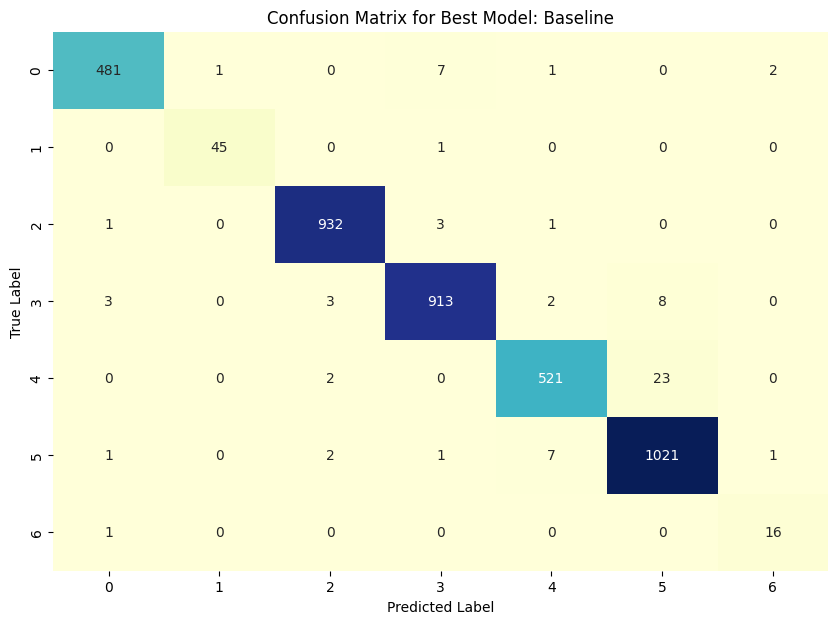

In [26]:
# Determine the best model based on accuracy c
best_model_index = results_df['Accuracy'].idxmax()
best_method = results_df.loc[best_model_index, 'Method']

# Select the corresponding predictions and trained model
if best_method == 'SDS':
    best_model = baseline_model
    y_pred_best = y_pred_sds
elif best_method == 'RFE':
    best_model = baseline_model
    y_pred_best = y_pred_rfe
elif best_method == 'PCA':
    best_model = baseline_model
    y_pred_best = y_pred_pca
elif best_method == 'Baseline':
    best_model = baseline_model
    y_pred_best = y_pred_baseline
elif best_method == 'Filter Method':
    best_model = baseline_model
    y_pred_best = y_pred_filter
else:
    raise ValueError("Unknown best method.")

# Compute the confusion matrix for the best model
conf_matrix = confusion_matrix(y_test, y_pred_best)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title(f"Confusion Matrix for Best Model: {best_method}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [27]:
import plotly.express as px
import plotly.graph_objects as go

# Number of features selected by each model
num_features = {
    'SDS': np.sum(best_features_sds == 1),
    'RFE': len(best_features_rfe),
    'PCA': pca.n_components_,
    'Baseline': X_train.shape[1]  # Using all features for baseline
}

# Add this as a new column to your results dataframe
results_df['Num_Features'] = results_df['Method'].map(num_features)

# Create a bar plot with a line trace for the number of features
fig = go.Figure()

# Bar plot for Accuracy
fig.add_trace(go.Bar(
    x=results_df['Method'],
    y=results_df['Accuracy'],
    name='Accuracy',
    marker=dict(color=px.colors.sequential.Viridis[0]),
    yaxis='y1'
))

# Line trace for Number of Features
fig.add_trace(go.Scatter(
    x=results_df['Method'],
    y=results_df['Num_Features'],
    name='Number of Features',
    mode='lines+markers',
    line=dict(color='red', width=2),
    yaxis='y2'
))

# Create two y-axes: one for accuracy and one for the number of features
fig.update_layout(
    title="Accuracy and Number of Features by Model",
    xaxis=dict(title='Method'),
    yaxis=dict(
        title='Accuracy',
        range=[0, 1],
    ),
    yaxis2=dict(
        title='Number of Features',
        overlaying='y',
        side='right',
    ),
    showlegend=True
)

# Show the interactive plot
fig.show()


In [28]:
# Create a bar plot using Plotly
fig = px.bar(results_df,
             x='Method',
             y='Accuracy',
             title="Accuracy Comparison of Feature Selection and Baseline Methods",
             labels={'Accuracy': 'Accuracy', 'Method': 'Method'},
             color='Method',
             color_discrete_sequence=px.colors.sequential.Viridis)

# Show the interactive plot
fig.update_yaxes(range=[0, 1])  # Set y-axis limit from 0 to 1
fig.show()